In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as color
import skimage.data as skdata
from project.algorithms.simulation import dummy_object, ptychogram, mesh, illumination_beam
from project.algorithms.utils import circ_aperture, normalize, hsv_convert
from project.algorithms.reconstruction import epie

In [2]:
# Turn off for white background/jupyter notebook
background_dark = True
if background_dark:
    plt.style.use('dark_background')

In [3]:
intensity = np.array(plt.imread('lena.tif'))
phase = skdata.camera()
obj = dummy_object(intensity=intensity, phase=phase, output_shape=(256, 256))
box_shape= (161, 161)   # the size of reconstruction box
r = 0.625
illumination = illumination_beam(box_shape, beam_radius=r)
illumination = normalize(illumination)
norm = color.Normalize(-np.pi, np.pi)
rainbow = cm.ScalarMappable(norm=norm, cmap='rainbow')
gray = cm.ScalarMappable(cmap='gray')

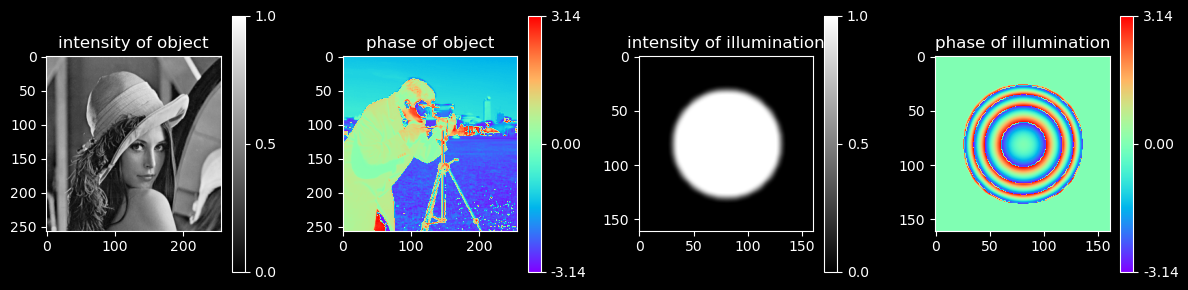

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(np.abs(obj), cmap='gray')
axes[0].set_title('intensity of object')
plt.colorbar(gray, ax=axes[0], ticks=[0, 0.5, 1], format='%.1f')
axes[1].imshow(np.angle(obj), cmap='rainbow')
axes[1].set_title('phase of object')
plt.colorbar(rainbow, ax=axes[1], ticks=[-np.pi, 0, np.pi], format='%.2f')
axes[2].imshow(np.abs(illumination), cmap='gray')
axes[2].set_title('intensity of illumination')
plt.colorbar(gray, ax=axes[2], ticks=[0, 0.5, 1], format='%.1f')
axes[3].imshow(np.angle(illumination), cmap='rainbow')
plt.colorbar(rainbow, ax=axes[3], ticks=[-np.pi, 0, np.pi], format='%.2f')
axes[3].set_title('phase of illumination')
plt.tight_layout()
plt.savefig("ground_truth")

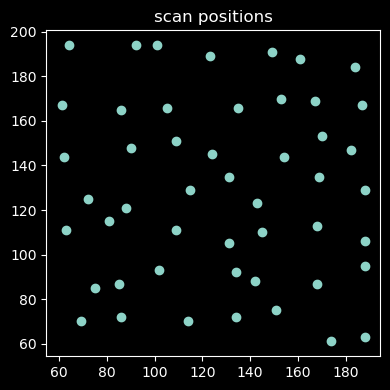

In [21]:
positions = mesh((256, 256), 40, 0.75, 7, error=7)
# positions = np.load('positions.npy')
# guess_position1 = mesh((256, 256), 50, 0.85, 7, error=0)
patterns = []
for position in positions:
    pattern = ptychogram(obj, illumination, position)
    patterns.append(pattern)
plt.figure(figsize=(4, 4))
plt.scatter(*np.transpose(positions))
# plt.scatter(*np.transpose(guess_position1))
plt.title('scan positions')
plt.tight_layout()
# plt.savefig('positions')

In [22]:
guess_probe = circ_aperture(box_shape, radius=0.5).astype('complex')
guess_position = positions
recon_obj, rencon_probe, loss = epie(patterns, guess_position, (256, 256), guess_probe=guess_probe, track_error=True, n_iter=300,random_update=False)

In [23]:
recon_obj1, rencon_probe1, loss1 = epie(patterns, guess_position, (256, 256), guess_probe=guess_probe, track_error=True, n_iter=300, random_update=True)

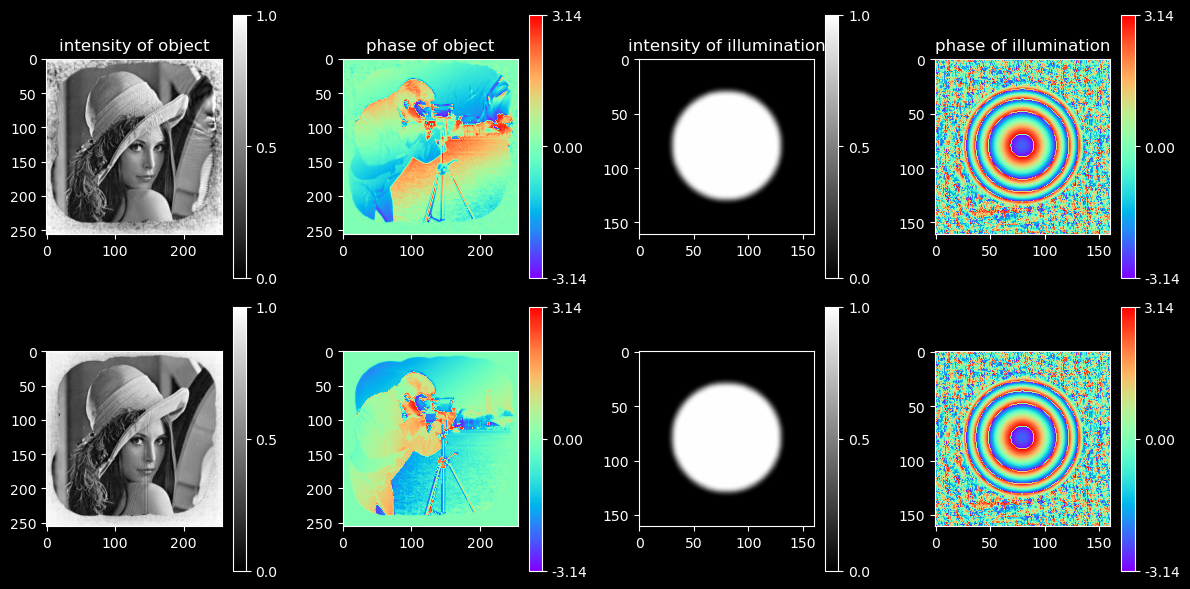

In [24]:
os = [recon_obj, recon_obj1]
ps = [rencon_probe, rencon_probe1]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(2):
    axes[i, 0].imshow(np.abs(os[i]), cmap='gray')
    plt.colorbar(gray, ax=axes[i, 0], ticks=[0, 0.5, 1], format='%.1f')
    axes[i, 1].imshow(np.angle(os[i]), cmap='rainbow', vmin=-np.pi, vmax=np.pi)
    plt.colorbar(rainbow, ax=axes[i, 1], ticks=[-np.pi, 0, np.pi], format='%.2f')
    axes[i, 2].imshow(np.abs(ps[i]), cmap='gray')
    plt.colorbar(gray, ax=axes[i, 2], ticks=[0, 0.5, 1], format='%.1f')
    axes[i, 3].imshow(np.angle(ps[i]), cmap='rainbow')
    plt.colorbar(rainbow, ax=axes[i, 3], ticks=[-np.pi, 0, np.pi], format='%.2f')
axes[0, 0].set_title('intensity of object')
axes[0, 1].set_title('phase of object')
axes[0, 2].set_title('intensity of illumination')
axes[0, 3].set_title('phase of illumination')
plt.tight_layout()
plt.savefig('ePIE result')

In [15]:
# np.save('positions.npy', positions)
# plt.savefig('positions')

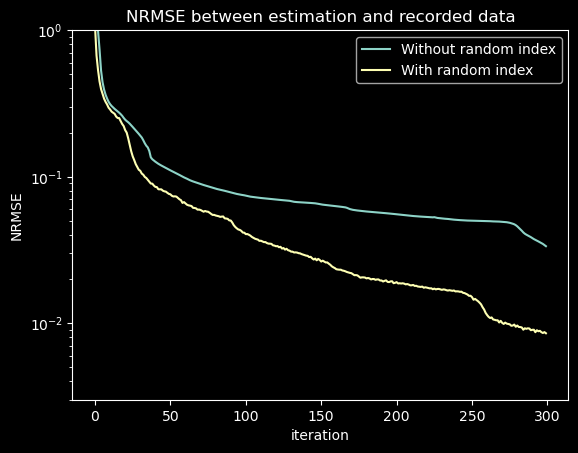

In [25]:
plt.plot(loss, label='Without random index')
plt.plot(loss1, label='With random index')
plt.title('NRMSE between estimation and recorded data')
plt.xlabel('iteration')
plt.ylabel('NRMSE')
plt.yscale('log')
plt.ylim(0.003,1)
plt.legend()
plt.savefig('loss')